In [91]:
import pandas as pd
data_directory = '../data/'

In [92]:
time_series_metadata = pd.DataFrame(columns=['Units', 'Source'])
time_series_metadata.index.name='Name'

In [93]:
df = pd.read_csv(data_directory+'original/Farmer_Lafond_Data.csv', index_col=0)

for col in df.columns:
    time_series_metadata.ix[col, 'Units'] = df[col].iloc[0]
    time_series_metadata.ix[col, 'Source'] = 'Farmer_Lafond'
    time_series_metadata.ix[col, 'Type'] = 'Price'


df = df.iloc[2:]

for col in df.columns:
    time_series_metadata.ix[col, 'n'] = df[col].notnull().sum()
    time_series_metadata.ix[col, 'Start'] = df[col].dropna().index[0]
    time_series_metadata.ix[col, 'Stop'] = df[col].dropna().index[-1]    

In [94]:
time_series = df.copy()

In [95]:
from os import listdir
from numpy import sort
data_directories = sort(listdir(data_directory+'original/Benson_Magee_Data/'))

In [96]:
for d in data_directories:
    if d.startswith('.'):
        continue
    files = sort(listdir(data_directory+'original/Benson_Magee_Data/%s/'%d))
    for f in files:
        if f.endswith('.xlsx'):
            df = pd.read_excel(data_directory+'original/Benson_Magee_Data/%s/%s'%(d,f),sheetname='rawdata',index_col=0)
            col = f.split('_v1')[0]
            df = df[df.columns[0]]
            time_series_metadata.ix[col, 'Units'] = df.name
            time_series_metadata.ix[col, 'Source'] = 'Magee_et_al'
            time_series_metadata.ix[col, 'n'] = df.dropna().shape[0]
            time_series_metadata.ix[col, 'Start'] = df.dropna().index[0]
            time_series_metadata.ix[col, 'Stop'] = df.dropna().index[-1]
            df.name = col
            df.index = df.index.astype('float')
            df = 1/df
            df = df.groupby(level=0).min()
            units = time_series_metadata.ix[col, 'Units']
            if "cost" in units or "price" in units or "USD" in units or "$" in units or "dollar" in units:
                time_series_metadata.ix[col, 'Type'] = 'Price'
            else:
                time_series_metadata.ix[col, 'Type'] = 'Performance'
                df = df.cummin().drop_duplicates() #Non-dominated
            time_series = time_series.join(df, how='outer')

In [97]:
time_series = time_series.astype('float')

In [100]:
time_series.to_csv(data_directory+'time_series.csv')
time_series_metadata.to_csv(data_directory+'time_series_metadata.csv')

Populating the interactive namespace from numpy and matplotlib


/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/home/jeffrey_alstott/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2ba2760cb620> (for post_execute):


ValueError: 
_wkm_
     ^
Expected {snowflake | accent | symbol | c_over_c | function | group | frac | stackrel | binom | genfrac | sqrt | overline | operatorname} (at char 5), (line:1, col:6)

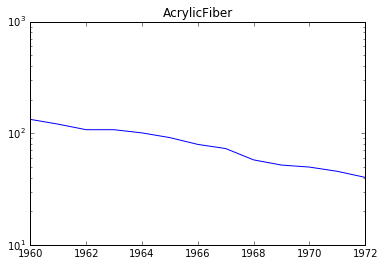

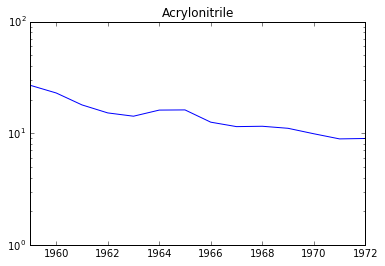

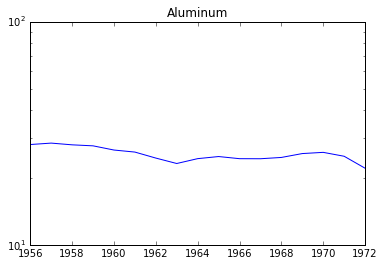

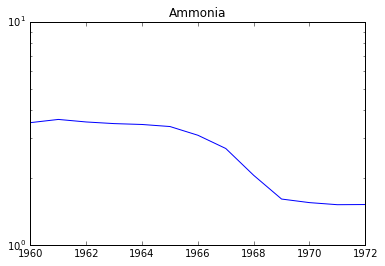

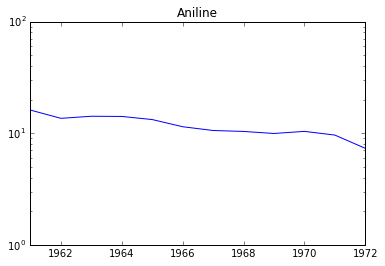

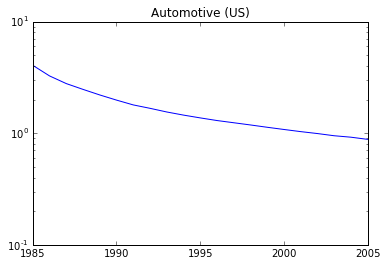

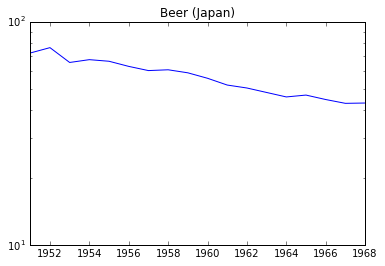

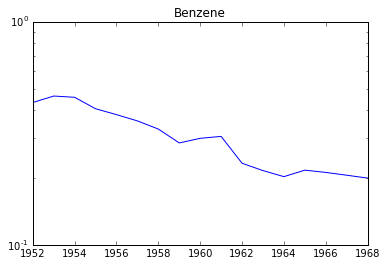

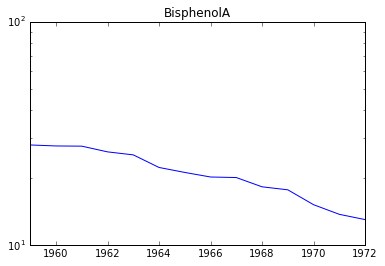

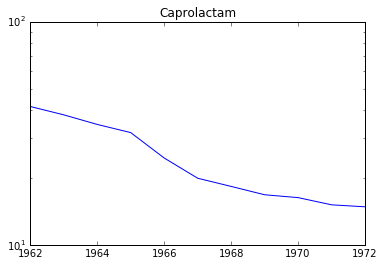

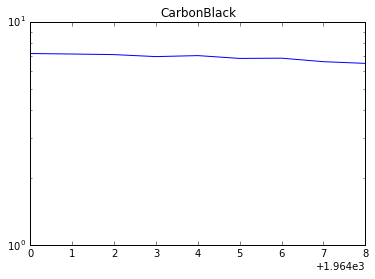

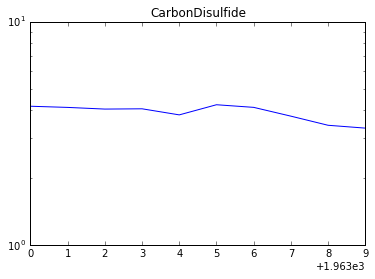

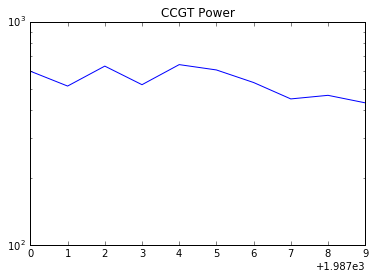

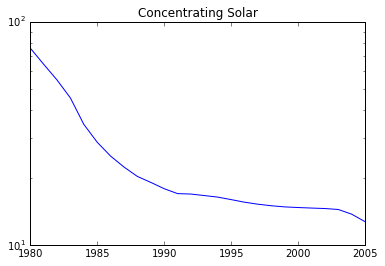

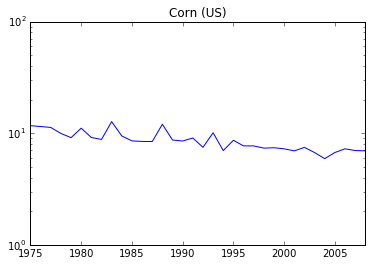

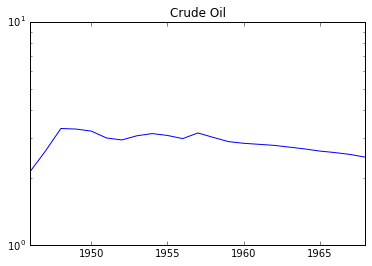

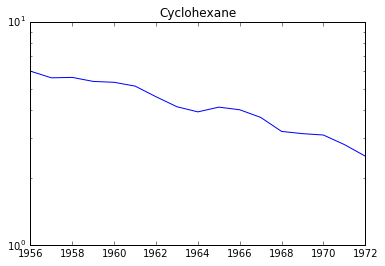

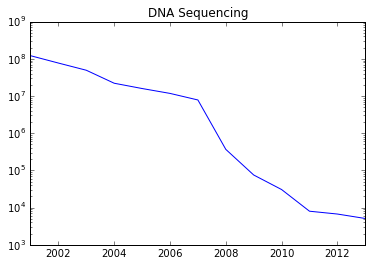

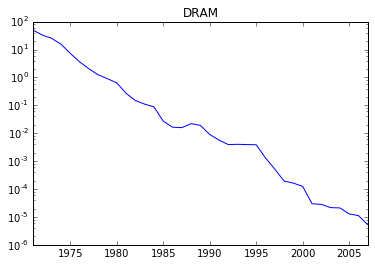

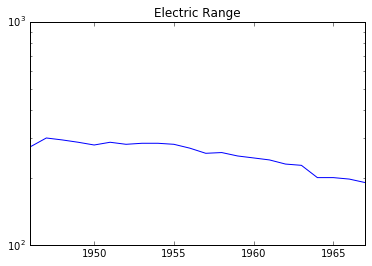

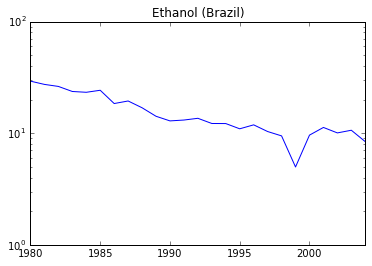

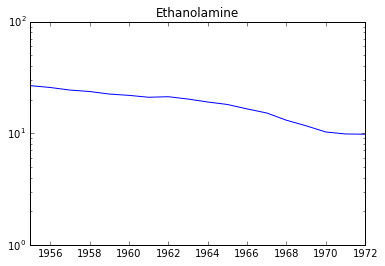

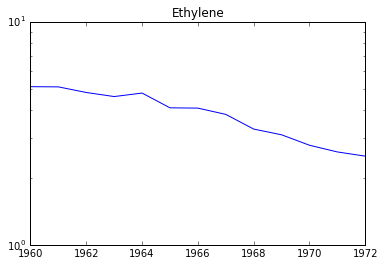

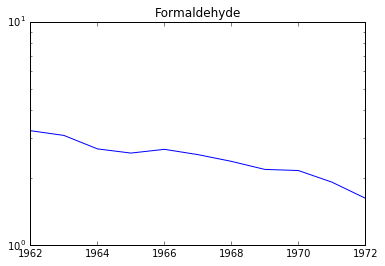

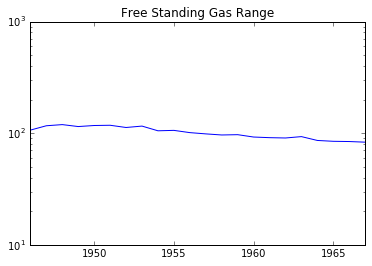

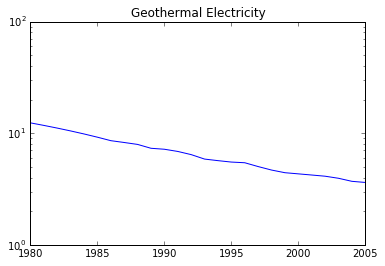

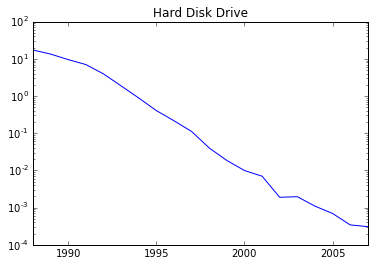

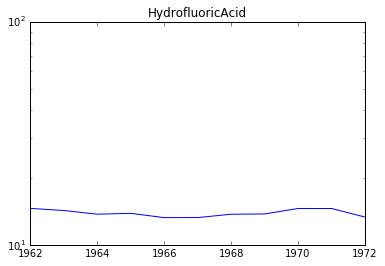

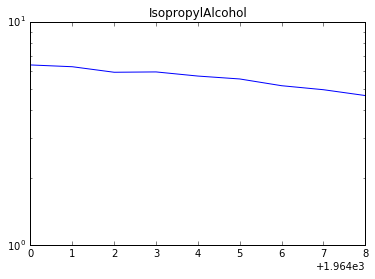

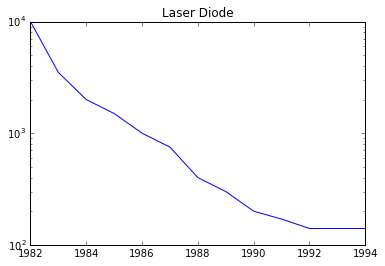

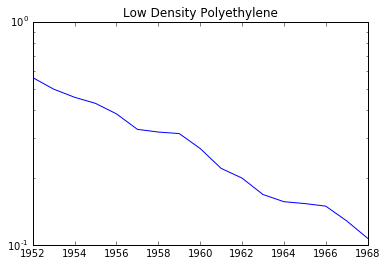

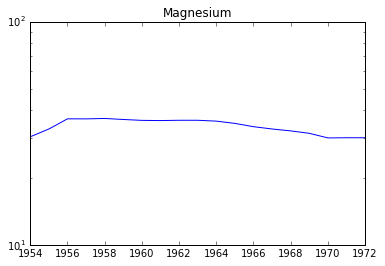

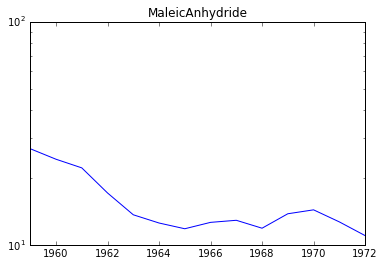

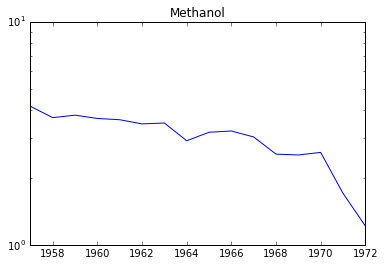

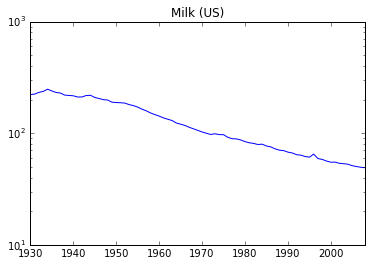

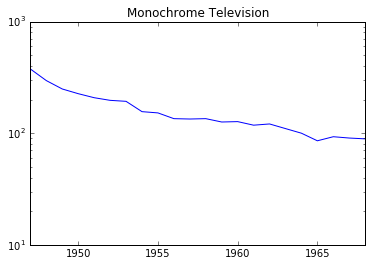

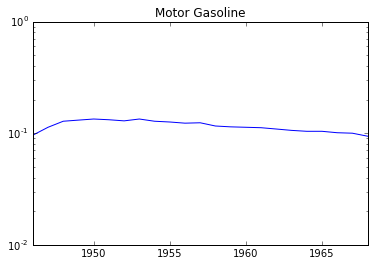

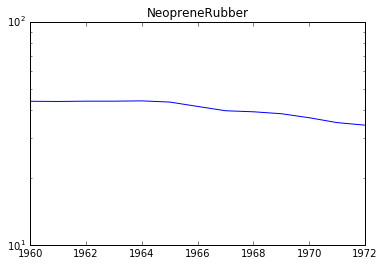

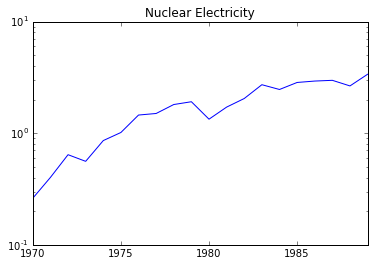

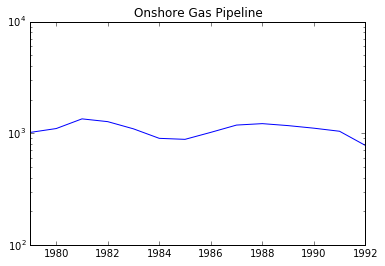

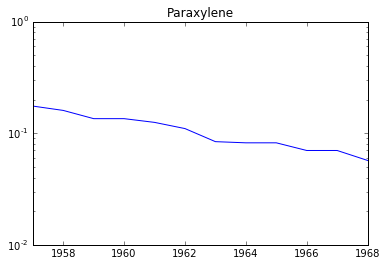

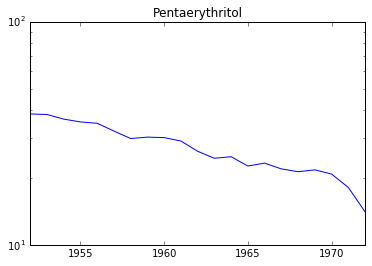

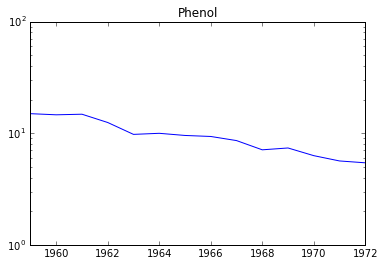

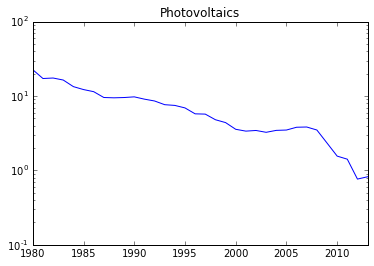

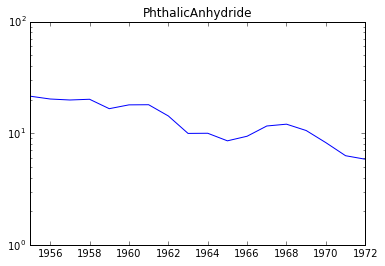

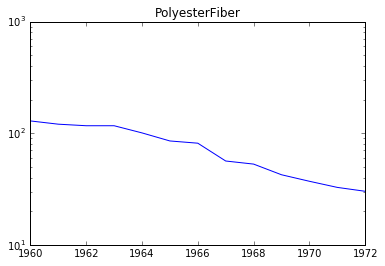

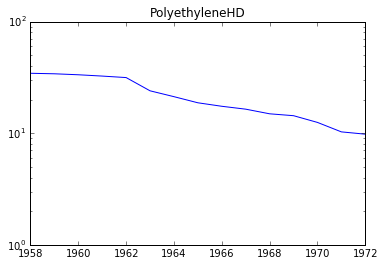

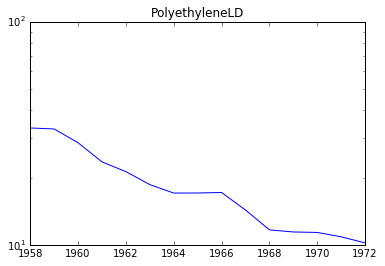

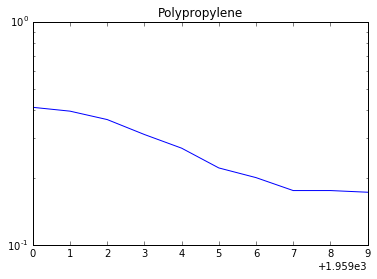

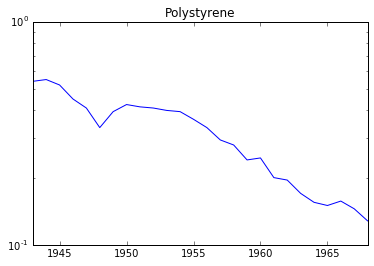

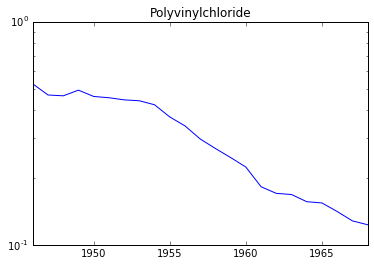

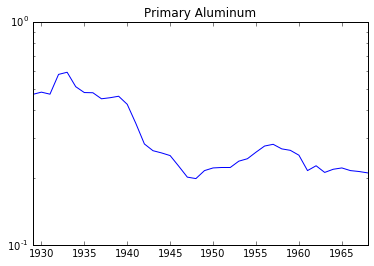

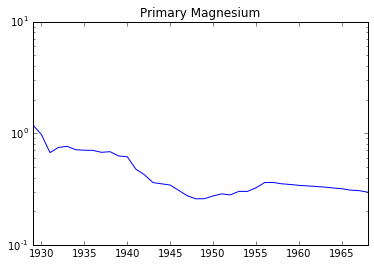

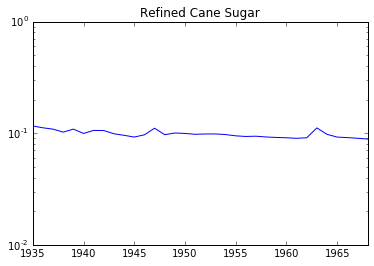

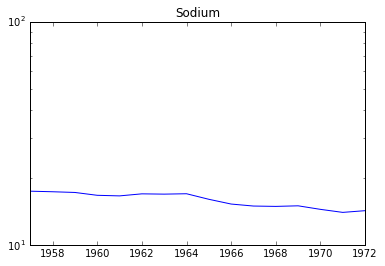

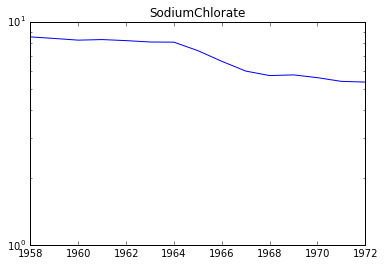

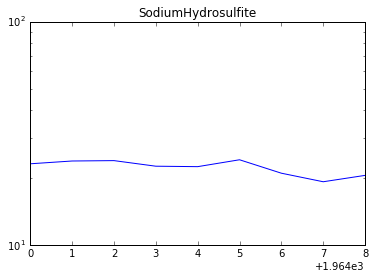

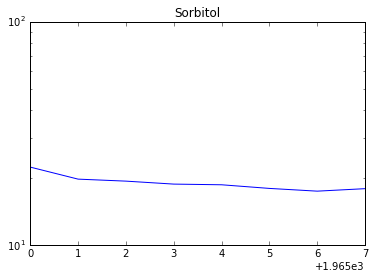

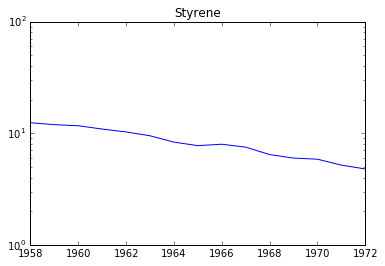

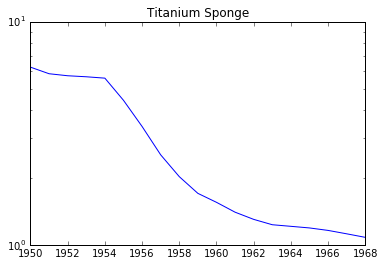

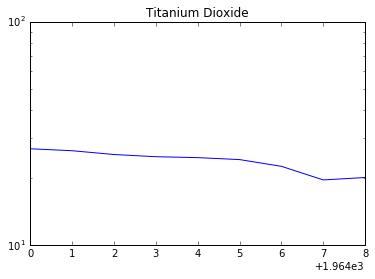

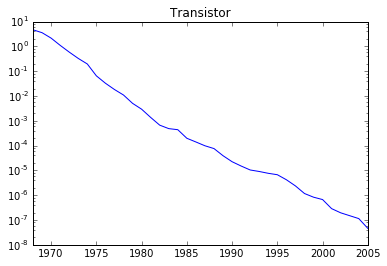

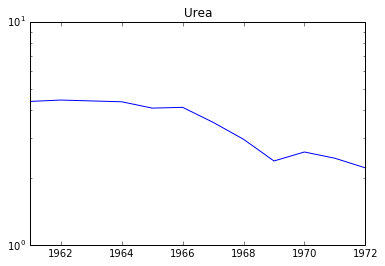

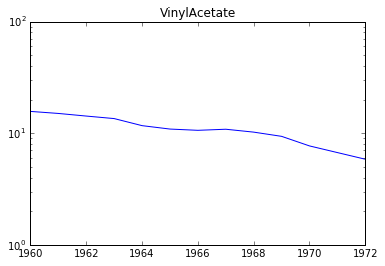

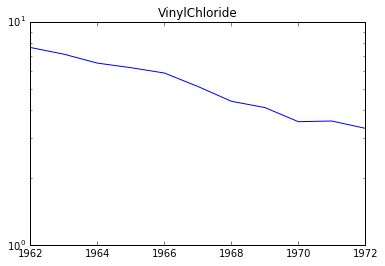

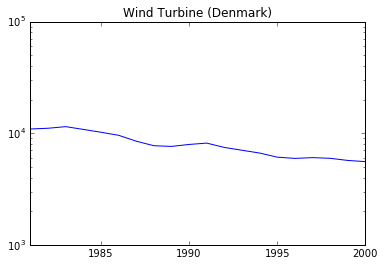

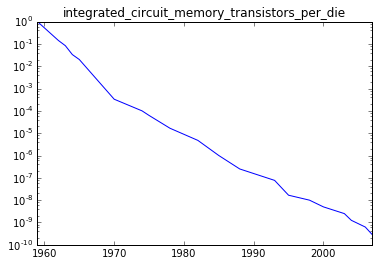

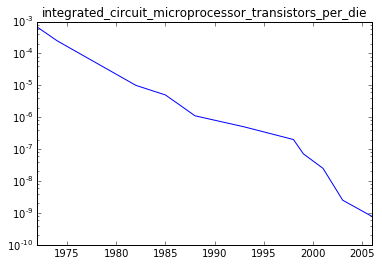

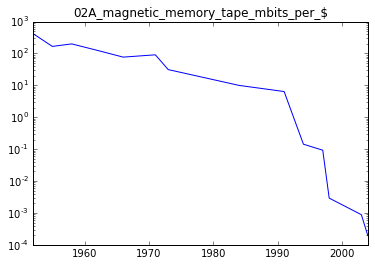

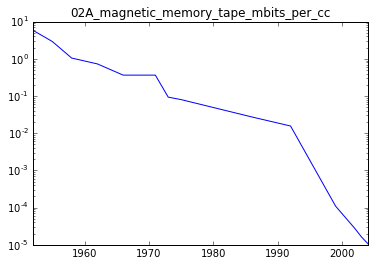

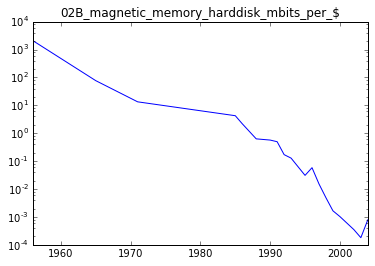

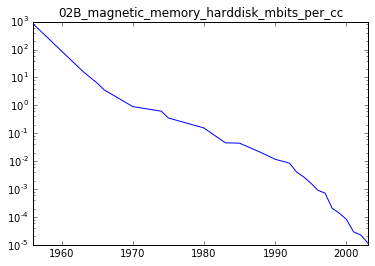

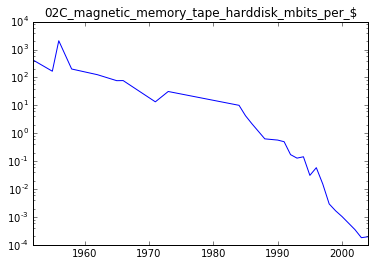

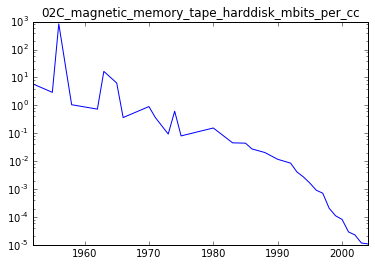

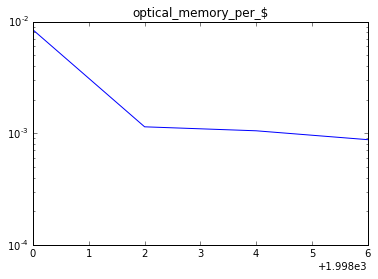

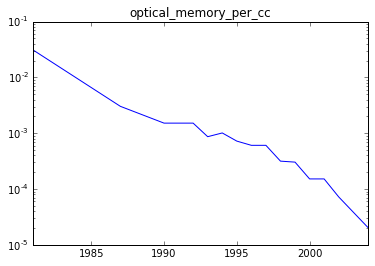

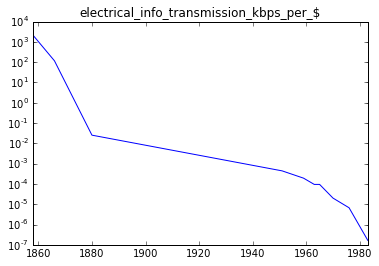

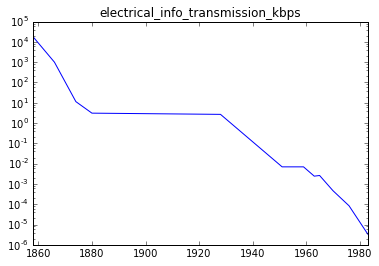

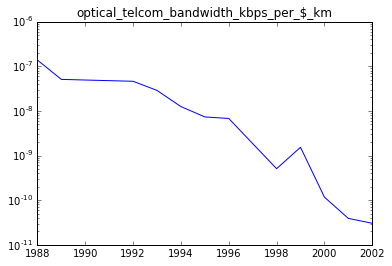

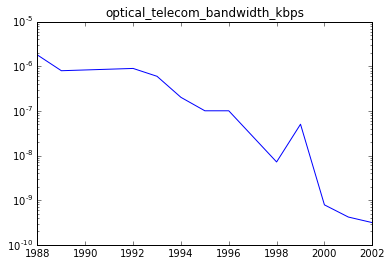

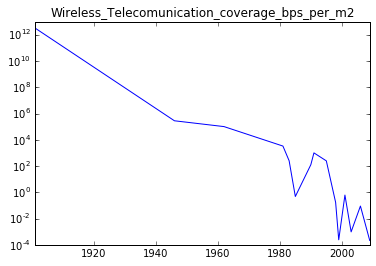

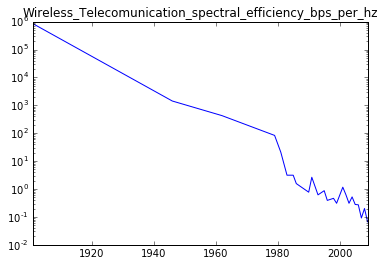

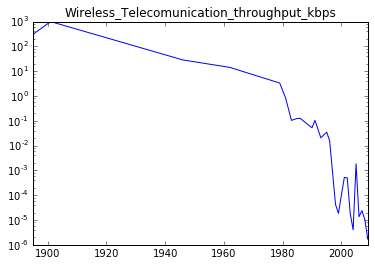

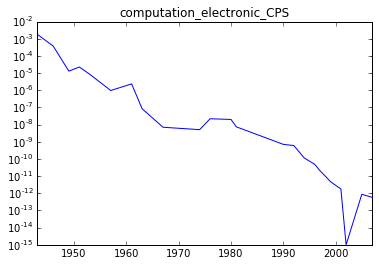

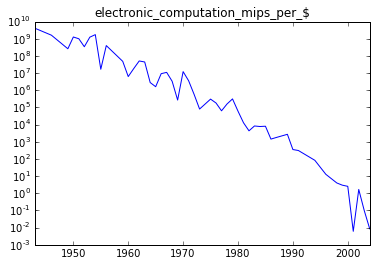

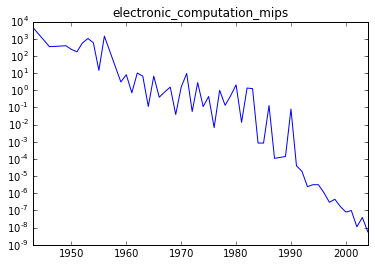

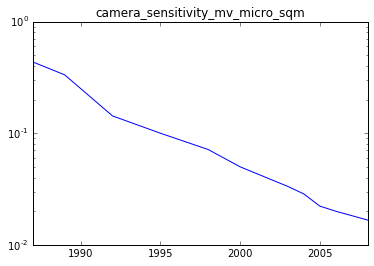

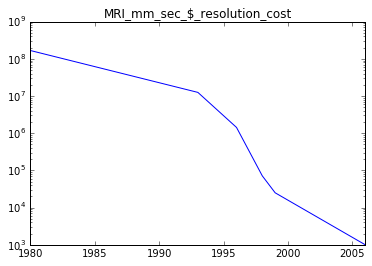

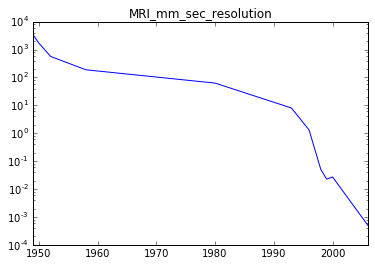

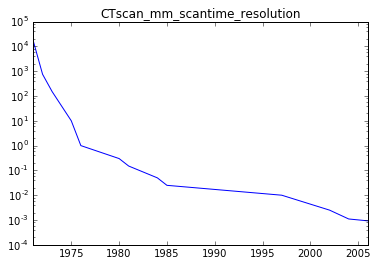

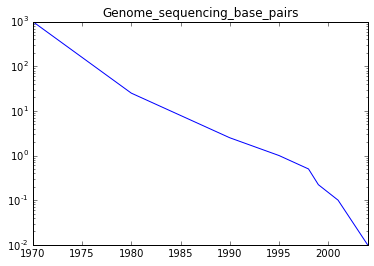

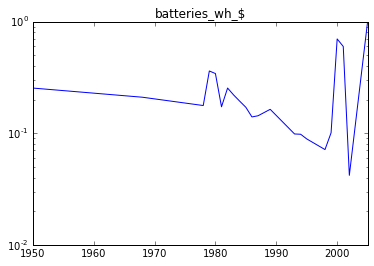

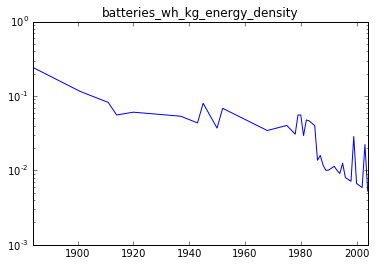

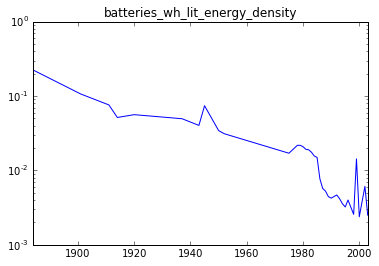

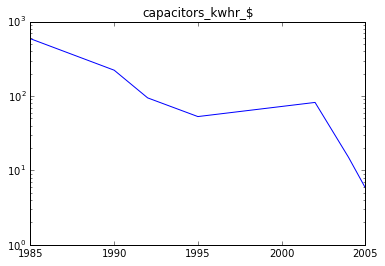

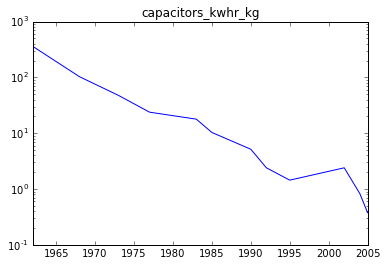

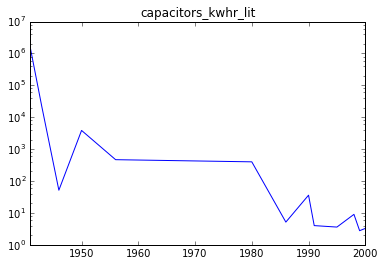

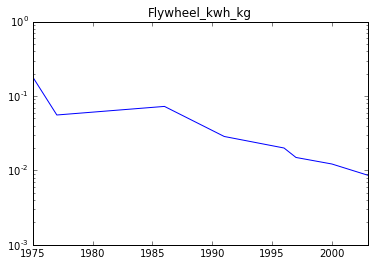

ValueError: 
_wkm_
     ^
Expected {snowflake | accent | symbol | c_over_c | function | group | frac | stackrel | binom | genfrac | sqrt | overline | operatorname} (at char 5), (line:1, col:6)

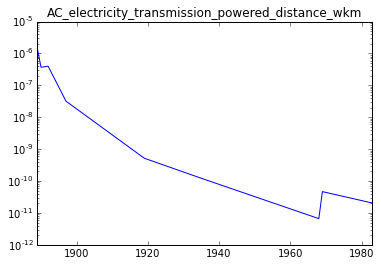

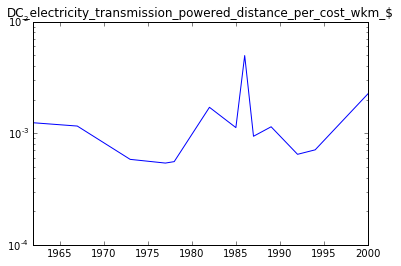

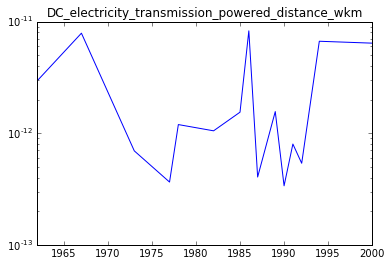

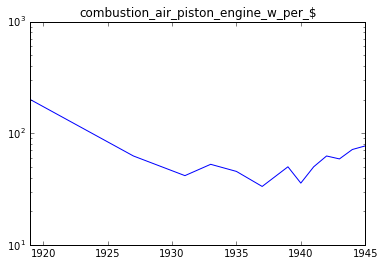

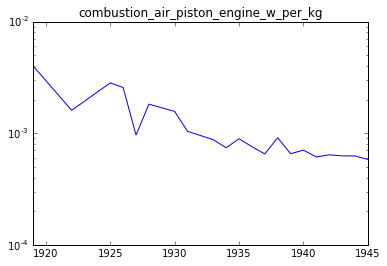

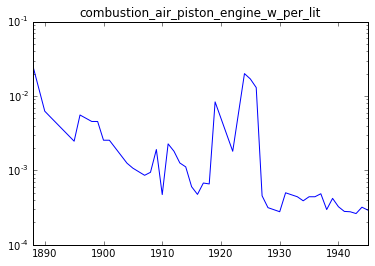

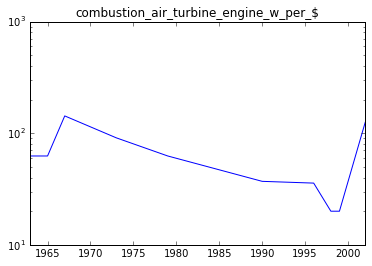

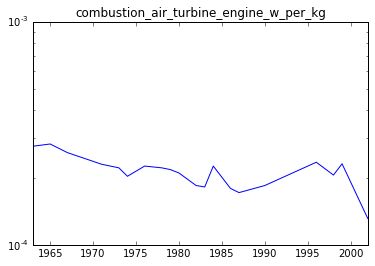

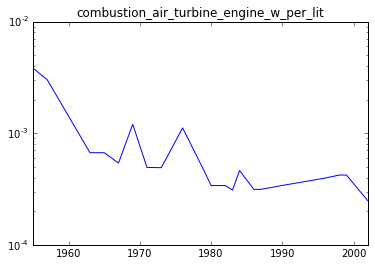

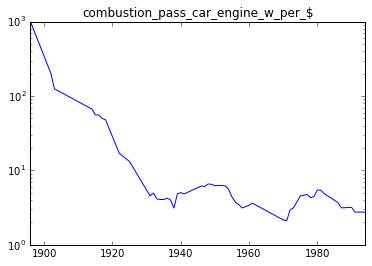

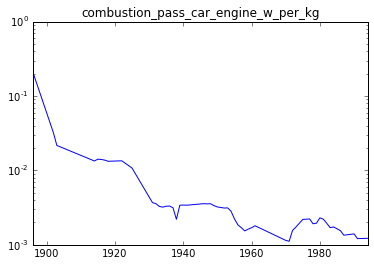

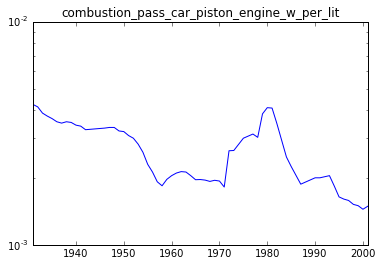

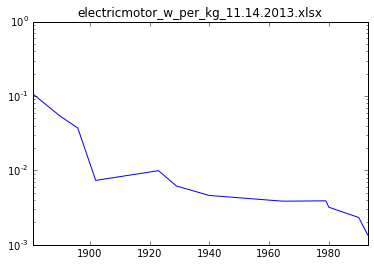

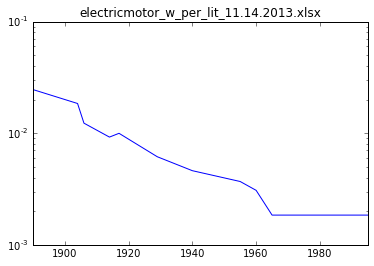

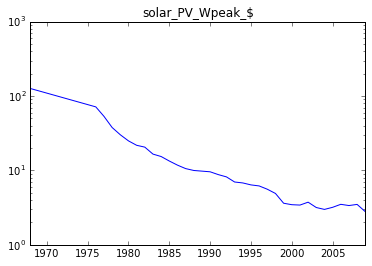

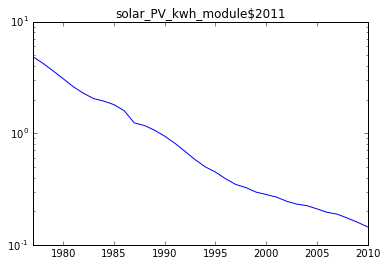

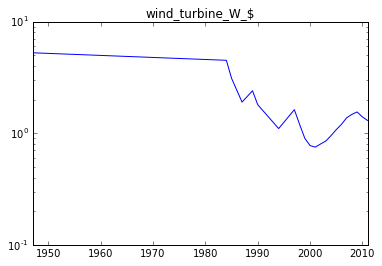

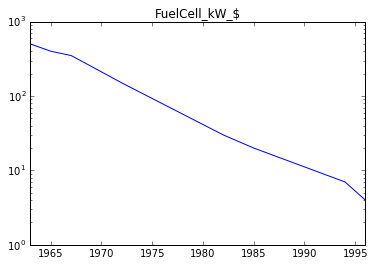

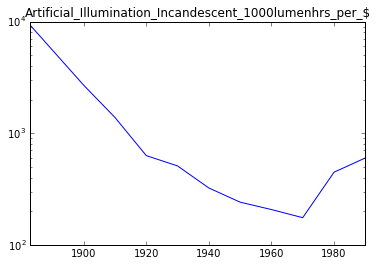

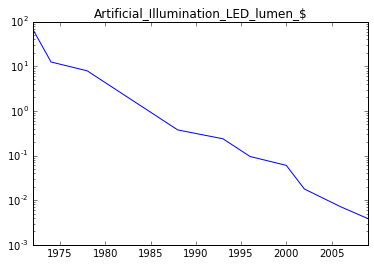

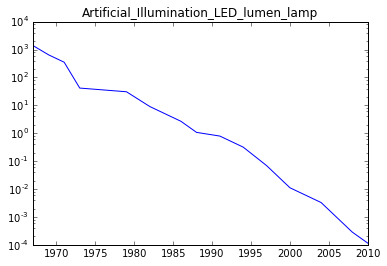

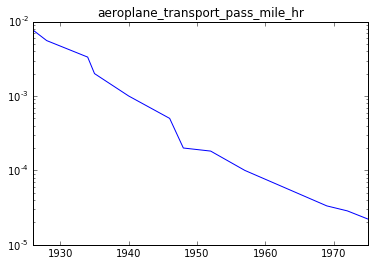

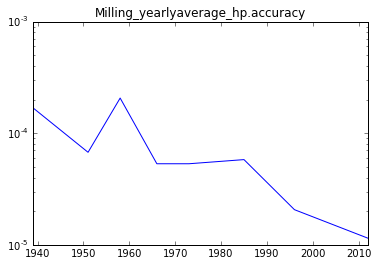

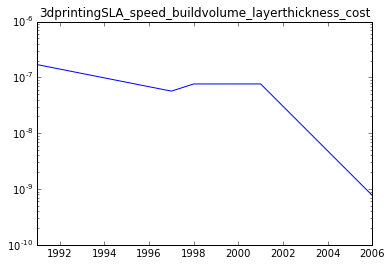

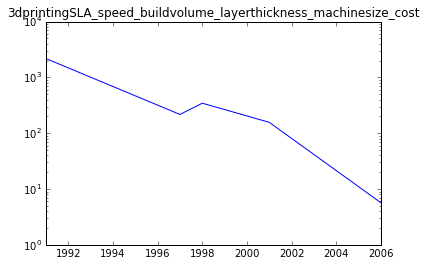

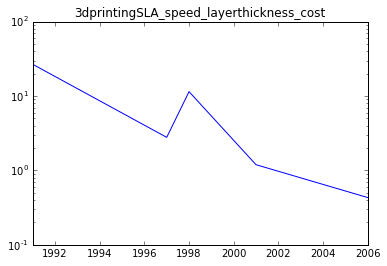

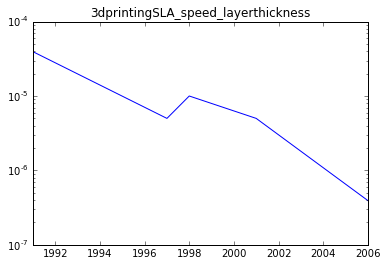

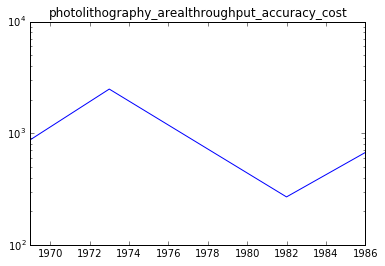

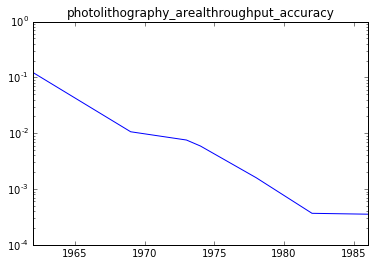

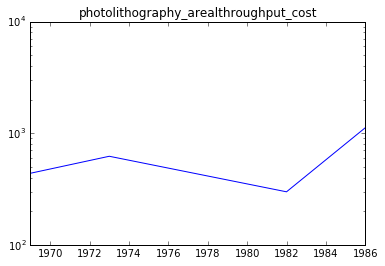

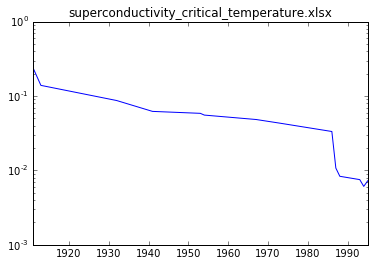

In [69]:
%pylab inline

for c in time_series.columns:
    figure()
    time_series[c].dropna().plot(legend=False)
    yscale('log')
    title(c)

In [101]:
time_series_metadata[time_series_metadata['Source']=='Farmer_Lafond'].shape

(66, 6)

In [102]:
time_series_metadata[time_series_metadata['Source']=='Magee_et_al'].shape

(64, 6)

In [107]:
sum(time_series_metadata[time_series_metadata['Source']=='Magee_et_al']['n']>10)

47